In [74]:
!pip install -q pandasql

In [75]:
import numpy as np
import pandas as pd
from pandasql import sqldf
mysql = lambda q : sqldf(q , globals())
import unicodedata
import re
import zlib
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import textblob


pd.set_option('display.max_columns' , 10)
pd.set_option('display.max_rows' , 50)
pd.set_option('display.max_colwidth' , 350)


In [76]:
def seed_everything(seed: int):
    import random
    import torch
    import  os

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(seed=42)

In [77]:
!pip install contractions
!pip install textsearch
!pip install textstat
!pip install sentence_transformers

# Features
* **text length counts** :
features like character length and word length are quite common to be significant in text datasets. For documents or paragraph-like data points, you can use sentence length mean and std values as features.


* **non-dictionary word counts** :
count/ratio of non-dictionary words or OOV(out of vocab) words in the text. It can be a pseudo-feature representing how formal the text is. Twitter type social media datasets will have higher ratios compared to Wikipedia articles.


* **readability metrics**:
Metrics like Flesch-Kincaid Readability Test and SMOG can be used. Essentially, these are ratios of complex words(polysyllables) to the total number of words or sentences — which are hypothesized to signal how easily readable a piece fo text is.


* **unique word ratios**:
ratio of number of unique words/total words. This feature gives you a sense of word repetitions in the data points. For a deeper analysis of this type of feature, you can look into TF-IDF models.


* **sentence types** :
Features such as count, or boolean variable for the presence of questions, exclamations, and particular punctuations.
emojis and hashtags
A feature of the count or boolean for their presence in a text. Sentiments of these features can also be further used on top of these.


* **Complex/Deep Features** :
Now let’s look at slightly complex features. These features typically require higher machine computation resources; GPU's for large datasets(100K+ data-points). Also, these are harder and time-consuming to construct on your own, so you’ll end up using standard libraries for these. I will mention and compare the famous libraries for each of the following.
part of speech(pos)
If there’s a single feature I have used the most in my experience, it’s the Part-Of-Speech(POS) tags. They are incredibly powerful.


* **named entity recognition(ner)**
Another related sibling of POS tagging is NER tagging. Again, spaCy is my choice for it. NER is used to identify named-entities like person names, organizations, locations, quantities, monetary values, percentages, etc. This is also a good feature that I use to filter my datasets for text generation tasks — as I don’t want the model to learn to output some of these proper noun entities.


* **sentiment analysis**
Sentiments and emotions are inevitably very important underlying features of any text. The sentiment of a sentence is usually highly relevant in translating to the target variable for common classification tasks. These are also great post-processing filters for most industrial applications — you usually don’t want to show negative sentiment sentences to a client.

In [78]:
# Loading Data
df_train = pd.read_csv('train_fake_news.csv')
df_test = pd.read_csv('test_fake_news.csv')
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [79]:
print('Nan Keywords = {}'.format(df_train['keyword'].isna().sum()))
print('Nan Location = {}'.format(df_train['location'].isna().sum()))

Nan Keywords = 61
Nan Location = 2533


In [80]:
# Adding a column in train and test true when link in given in tweet text.

df_train['Link_given'] = mysql('''select case when text like '%http%' then 1 else 0 end as Link_given
from df_train ''')

df_test['Link_given'] = mysql('''select case when text like '%http%' then 1 else 0 end as Link_given
from df_test ''')

# Removing ULRs

In [81]:
def remove_URL(headline_text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', headline_text)

df_train['text'] = df_train['text'].apply(remove_URL)

In [82]:
mysql('''select text
from df_train
where text like '%http%'
''')

,text
0,Aftershock: Protect Yourself and Profit in the Next Global Financial Meltdown by David Wiedemer http


# Removing HTML tags

In [83]:
def remove_html(headline_text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',headline_text)

df_train['text'] = df_train['text'].apply(remove_html)

# Removing Accented Characters

In [84]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
df_train['text'] = df_train['text'].apply(remove_accented_chars)

# Removing Special Characters, Numbers and Symbols

In [85]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, ' ', text) #removing character with space
    return text
df_train['text'] = df_train['text'].apply(remove_special_characters)

# Expanding Contractions

In [86]:
import contractions

list(contractions.contractions_dict.items())[:20]
df_train['text'] = df_train['text'].apply(contractions.fix)

# Adding Sentiment

In [87]:
x_train_snt_obj = df_train['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_train['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
df_train['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]
df_train

,id,keyword,location,text,target,Link_given,Polarity,Subjectivity
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,0,0.000000,0.000000
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,0,0.100000,0.400000
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1,0,-0.018750,0.387500
3,6,NaN,NaN,13 000 people receive wildfires evacuation orders in California,1,0,0.000000,0.000000
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes,1,1,0.000000,1.000000
7609,10870,NaN,NaN,aria ahrary TheTawniest The out of control wild fires in California even in the Northern part of the state Very troubling,1,0,0.150000,0.350000
7610,10871,NaN,NaN,M1 94 01 04 UTC 5km S of Volcano Hawaii,1,1,0.000000,0.000000
7611,10872,NaN,NaN,Police investigating after an e bike collided with a car in Little Portugal E bike rider suffered serious non life threatening injuries,1,0,-0.260417,0.583333


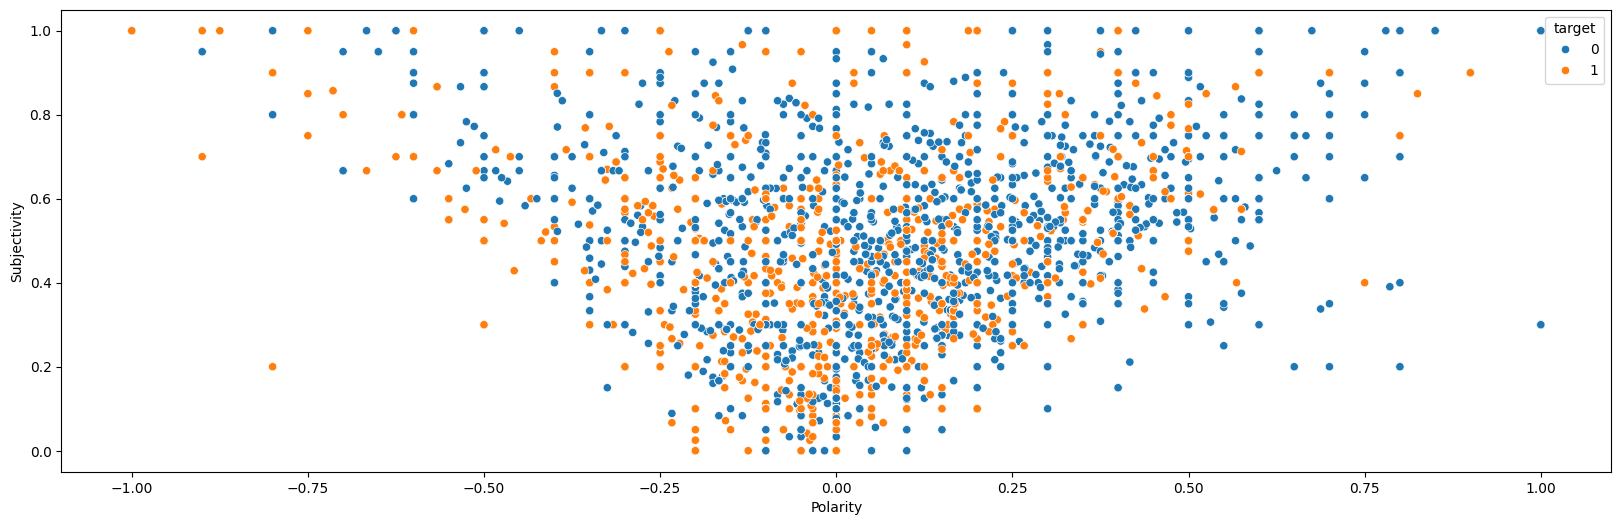

In [88]:
plt.figure(figsize =(20,6))
# sns.scatterplot(df_train['Polarity'] , df_train['Subjectivity'] ,hue = df_train['target']);
sns.scatterplot(x = df_train['Polarity'] , y = df_train['Subjectivity'] ,hue = df_train['target']);

In [89]:
df_train.describe()

,id,target,Link_given,Polarity,Subjectivity
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,0.521608,0.046280,0.298636
std,3137.116090,0.49506,0.499566,0.257502,0.323525
min,1.000000,0.00000,0.000000,-1.000000,0.000000
25%,2734.000000,0.00000,0.000000,0.000000,0.000000
50%,5408.000000,0.00000,1.000000,0.000000,0.200000
75%,8146.000000,1.00000,1.000000,0.120635,0.533333
max,10873.000000,1.00000,1.000000,1.000000,1.000000


In [90]:
mysql('''select sum(target) from df_train
where Polarity = 0''')

,sum(target)
0,1605


# Textstat for reading time and readibility

In [91]:
import textstat

In [92]:
df_train['Readibility_score'] = df_train['text'].apply(textstat.automated_readability_index)
df_train['Reading_time'] = df_train['text'].apply(textstat.reading_time)

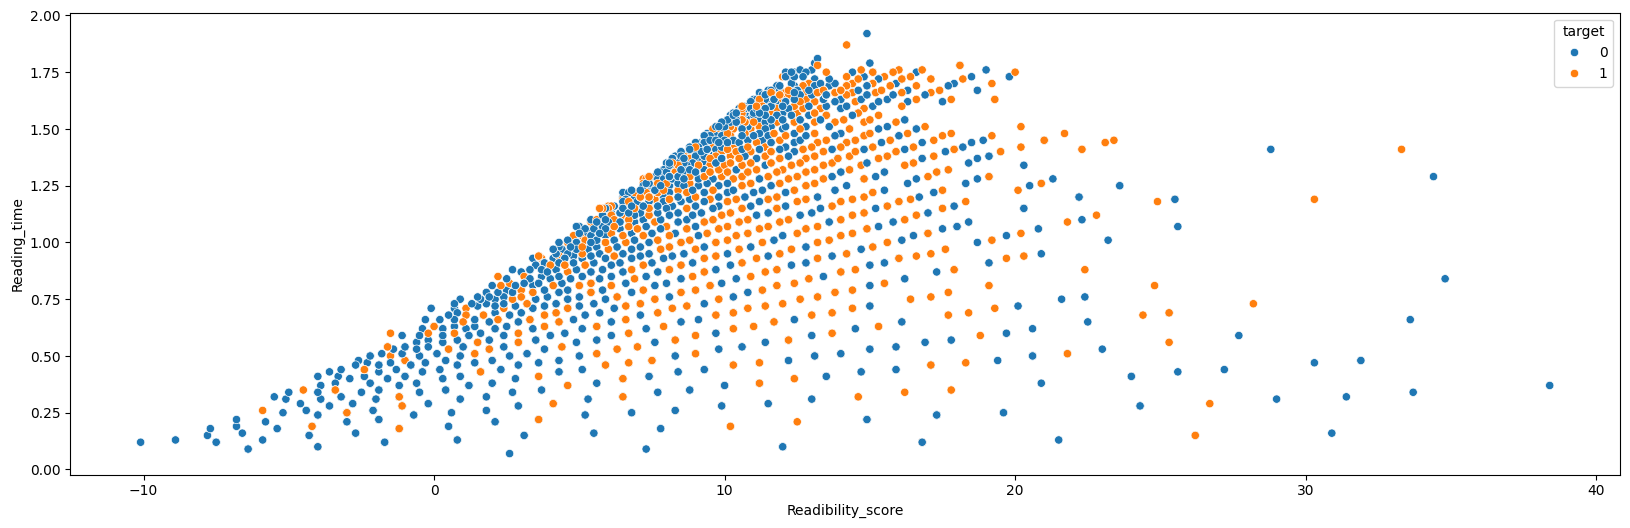

In [93]:
plt.figure(figsize =(20,6))
# sns.scatterplot(df_train['Readibility_score'] , df_train['Reading_time'] ,hue = df_train['target']);
sns.scatterplot(x=df_train['Readibility_score'] , y=df_train['Reading_time'] ,hue = df_train['target']);

In [94]:
df_train['linsear_write_text'] = df_train['text'].apply(textstat.linsear_write_formula)
df_train['wps_text'] = df_train['text'].apply(textstat.words_per_sentence)

In [95]:
from nltk.tokenize import word_tokenize

In [96]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [110]:
def calculate_ttr(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Calculate the number of unique words (types)
    unique_words = set(words)
    num_unique_words = len(unique_words)

    # Calculate the total number of words (tokens)
    num_total_words = len(words)

    # Calculate the TTR (Type-Token Ratio)
    if num_total_words > 0:
        ttr = num_unique_words / num_total_words
        return ttr
    else:
        return 0

# # Sample text
# text = "Natural Language Processing (NLP) is a subfield of artificial intelligence focused on the interaction between computers and humans through natural language. NLP techniques allow computers to understand, interpret, and generate human language."

# # Calculate the Lexical Diversity Score using TTR
# lexical_diversity_score = calculate_ttr(text)

# print("Lexical Diversity Score (TTR):", lexical_diversity_score)
df_train['Lexical_diversity'] = df_train['text'].apply(calculate_ttr)

df_train['text'] = df_train['text'].apply(str.lower)
df_train['text'] = df_train['text'].apply(str.strip)

#Checking Location

In [98]:
df_train['location'].fillna('None' , inplace = True)

# Removing Duplicate Rows

In [99]:
duplicaterow = df_train[df_train[['text' ,'target','keyword']].duplicated()]
duplicaterow

,id,keyword,location,text,target,...,Readibility_score,Reading_time,linsear_write_text,wps_text,Lexical_diversity
48,68,ablaze,Live On Webcam,check these out nsfw,0,...,0.6,0.25,1.0,4.0,1.0
106,156,aftershock,US,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
114,164,aftershock,Switzerland,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
115,165,aftershock,US,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
116,168,aftershock,None,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7538,10777,wreckage,None,wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0
7539,10779,wreckage,Maharashtra,wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0
7540,10780,wreckage,Mumbai,wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0
7541,10782,wreckage,"New Delhi,India",wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0


In [100]:
df_train = mysql('''select *
from df_train
except
select * from
duplicaterow
''')
df_train

,id,keyword,location,text,target,...,Readibility_score,Reading_time,linsear_write_text,wps_text,Lexical_diversity
0,1,None,None,our deeds are the reason of this earthquake may allah forgive us all,1,...,5.4,0.82,5.5,13.0,1.000000
1,4,None,None,forest fire near la ronge sask canada,1,...,2.9,0.46,2.5,7.0,1.000000
2,5,None,None,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1,...,12.9,1.60,16.0,22.0,0.818182
3,6,None,None,13 000 people receive wildfires evacuation orders in california,1,...,11.8,0.81,5.5,9.0,1.000000
4,7,None,None,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1,...,7.2,1.03,7.0,16.0,0.937500
...,...,...,...,...,...,...,...,...,...,...,...
7010,10869,None,None,two giant cranes holding a bridge collapse into nearby homes,1,...,7.6,0.75,4.0,10.0,1.000000
7011,10870,None,None,aria ahrary thetawniest the out of control wild fires in california even in the northern part of the state very troubling,1,...,11.7,1.48,11.5,21.0,0.857143
7012,10871,None,None,m1 94 01 04 utc 5km s of volcano hawaii,1,...,-2.4,0.44,4.0,10.0,1.000000
7013,10872,None,None,police investigating after an e bike collided with a car in little portugal e bike rider suffered serious non life threatening injuries,1,...,14.0,1.67,16.0,22.0,0.954545


# Adding columns of numbers

In [101]:
df_train['char_count'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

In [102]:
!pip install -U spacy

In [103]:
# python3 -m spacy download nl_core_news_sm
from spacy.cli import download
download("en_core_web_sm")
download("nl_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [104]:
import nl_core_news_sm
nlp = nl_core_news_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()

In [105]:
import spacy

string = "Geert werkt sinds 2010 voor HAL."
print(string)
nlp = spacy.load('nl_core_news_sm')
doc = nlp(string)

filtered_string = ""
for token in doc:
    if token.pos_ in ['PROPN', 'NOUN', 'NUM']:
        new_token = " <{}>".format(token.ent_type_)
    elif token.pos_ == "PUNCT":
        new_token = token.text
    else:
        new_token = " {}".format(token.text)
    filtered_string += new_token
filtered_string = filtered_string[1:]
print(filtered_string)

Geert werkt sinds 2010 voor HAL.
<PERSON> werkt sinds <DATE> voor <ORG>.


# **Sentence Transformer**

In [106]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256 )
                                           #,tokenizer_name_or_path = 'nntadotzip/xlnet-base-cased-IUChatbot-ontologyDts-BertPretrainedTokenizerFast')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

sbert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [107]:
df_train

,id,keyword,location,text,target,...,linsear_write_text,wps_text,Lexical_diversity,char_count,word_count
0,1,None,None,our deeds are the reason of this earthquake may allah forgive us all,1,...,5.5,13.0,1.000000,69,13
1,4,None,None,forest fire near la ronge sask canada,1,...,2.5,7.0,1.000000,38,7
2,5,None,None,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1,...,16.0,22.0,0.818182,133,22
3,6,None,None,13 000 people receive wildfires evacuation orders in california,1,...,5.5,9.0,1.000000,64,9
4,7,None,None,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1,...,7.0,16.0,0.937500,87,16
...,...,...,...,...,...,...,...,...,...,...,...
7010,10869,None,None,two giant cranes holding a bridge collapse into nearby homes,1,...,4.0,10.0,1.000000,60,10
7011,10870,None,None,aria ahrary thetawniest the out of control wild fires in california even in the northern part of the state very troubling,1,...,11.5,21.0,0.857143,123,21
7012,10871,None,None,m1 94 01 04 utc 5km s of volcano hawaii,1,...,4.0,10.0,1.000000,41,10
7013,10872,None,None,police investigating after an e bike collided with a car in little portugal e bike rider suffered serious non life threatening injuries,1,...,16.0,22.0,0.954545,136,22


In [108]:
x = df_train['text'].to_list()

In [109]:
import time
s = time.time()
sentence_embeddings_1 = sbert_model.encode(x[:10000])
print(sentence_embeddings_1.shape)
print(time.time() - s)

(7015, 768)
679.5522692203522


In [111]:
Clusterdata = pd.DataFrame(sentence_embeddings_1 , columns = np.linspace(1 , 768 , num = 768))

In [112]:
Clusterdata

,1.0,2.0,3.0,4.0,5.0,...,764.0,765.0,766.0,767.0,768.0
0,0.003666,0.358392,0.234439,-0.623243,-0.237093,...,-0.124021,0.299599,-0.095702,0.210141,-0.413677
1,-0.301500,-0.001854,-0.165727,-0.018839,0.528077,...,-0.203356,0.119809,-0.134528,-0.300182,-0.063081
2,-0.273873,-0.059404,0.385689,-0.276570,0.598763,...,-0.494944,-0.374001,-0.177518,-0.155718,0.162706
3,0.058765,0.056242,0.235142,-0.002075,0.240990,...,-0.143229,0.078736,-0.295150,-0.018319,-0.279227
4,0.440228,-0.059738,0.368117,0.205874,0.230365,...,-0.128068,-0.226137,-0.519154,-0.057575,-0.077721
...,...,...,...,...,...,...,...,...,...,...,...
7010,0.690985,0.392383,-0.077546,-0.131674,0.306718,...,0.315844,0.081389,-0.261445,-0.205472,-0.005630
7011,-0.488128,0.127342,0.032622,-0.063040,0.208403,...,-0.160674,0.068630,-0.460172,-0.071713,-0.451857
7012,-0.050482,0.414682,0.432910,-0.078407,-0.096980,...,-0.245204,0.047200,-0.333653,0.399957,0.045723
7013,-0.143300,-0.437788,0.361666,0.046456,0.242764,...,-0.231987,-0.201007,-0.375070,-0.270510,0.162513


In [113]:
df_clust = pd.concat([df_train , Clusterdata] , axis = 1)

# Train Test Split to prevent data leakage

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
a = df_clust.drop(['keyword', 'location','text' , 'id' , 'target'] , axis = 1)
b = df_clust.loc[: , 'target']
a_train , a_test , b_train , b_test = train_test_split( a, b, test_size = 0.18 , random_state = 2837 , stratify = b)
a_train.shape , a_test.shape

((5752, 778), (1263, 778))

#Dimensionality Reduction

### PCA

In [116]:
from sklearn.decomposition import PCA

In [117]:
a_train.iloc[: , 10:]

,1.0,2.0,3.0,4.0,5.0,...,764.0,765.0,766.0,767.0,768.0
1840,-0.097332,0.137871,0.302261,0.271993,0.290832,...,0.191653,-0.031326,-0.613595,-0.006786,-0.369243
4727,-0.071298,0.141442,-0.157396,0.067508,-0.099493,...,0.114931,0.072866,-0.479441,0.136159,-0.209346
4284,-0.146353,-0.098161,0.301859,-0.092301,0.156699,...,-0.115929,-0.246415,-0.139442,-0.045235,-0.048688
1326,-0.408020,-0.172580,-0.268523,-0.134407,0.073740,...,-0.351309,-0.193963,-0.613516,0.071914,-0.351554
2695,-0.405021,-0.023117,0.284981,-0.119102,0.329981,...,-0.006569,-0.243310,-0.522984,0.053533,-0.082745
...,...,...,...,...,...,...,...,...,...,...,...
1559,0.268182,0.148909,0.261785,-0.036502,0.183785,...,-0.244910,-0.145894,-0.662131,-0.124766,0.009723
2662,-0.165515,-0.116386,0.026314,-0.055410,0.217838,...,0.197727,-0.234931,-0.515943,-0.223236,0.107912
3822,0.494516,0.134468,0.274415,-0.041899,0.037286,...,-0.273063,-0.109244,-0.365168,-0.107287,-0.188249
3909,0.257707,-0.089431,0.435716,-0.197069,0.102523,...,-0.372000,0.383881,-0.315447,-0.335877,-0.048636


In [118]:
a_train.columns = a_train.columns.astype(str)

In [119]:
pca_38 = PCA(n_components = .8  , random_state = 343)
pca_38.fit(a_train.iloc[: , 10:])
x_pca_38 = pca_38.transform(a_train.iloc[: , 10:])
print(sum(pca_38.explained_variance_ratio_ * 100))
x_pca_38.shape

80.02917486429214


(5752, 139)

In [120]:
df_99 = pd.DataFrame(x_pca_38, columns = np.linspace(1 , x_pca_38.shape[1], num =x_pca_38.shape[1]))

In [121]:
df_99.reset_index( inplace = True , drop = True)
a_train.reset_index(inplace = True , drop = True)

a_train = pd.concat([a_train.iloc[: , :10] , df_99] , axis = 1)

##### for test

In [122]:
a_test.columns = a_test.columns.astype(str)

In [123]:
x_pca_38_t = pca_38.transform(a_test.iloc[: , 10:])
df_99_t = pd.DataFrame(x_pca_38_t, columns = np.linspace(1 , x_pca_38.shape[1] , num =  x_pca_38.shape[1]))

df_99_t.reset_index( inplace = True , drop = True)
a_test.reset_index(inplace = True , drop = True)

a_test = pd.concat([a_test.iloc[: , :10] , df_99_t] , axis = 1)

# CATBOOST

In [124]:
!pip install -q catboost

In [125]:
import catboost as cb

In [150]:
a_train

,Link_given,Polarity,Subjectivity,Readibility_score,Reading_time,...,135.0,136.0,137.0,138.0,139.0
0,0,0.000000,0.000000,7.7,1.01,...,0.053702,-0.066447,0.281008,-0.123539,0.369849
1,1,-0.200000,0.700000,4.0,0.59,...,0.299179,-0.537782,0.043007,-0.228298,0.014892
2,0,0.000000,0.000000,5.6,0.57,...,0.102475,0.069707,0.038435,-0.079833,-0.219189
3,1,-0.013889,0.416667,8.6,0.95,...,0.274199,-0.209062,-0.026671,-0.336295,-0.031144
4,1,-0.200000,0.650000,9.3,0.98,...,0.005837,-0.024495,0.072008,0.000368,-0.114799
...,...,...,...,...,...,...,...,...,...,...,...
5747,0,0.000000,0.000000,3.7,0.85,...,0.347880,0.024375,0.570776,0.142206,0.319744
5748,1,0.000000,0.000000,15.5,1.31,...,-0.107358,0.234517,-0.080145,0.352240,-0.043010
5749,0,0.225000,0.600000,13.5,1.45,...,0.192908,0.251480,0.062585,-0.038748,-0.172532
5750,0,0.000000,0.000000,-1.6,0.40,...,0.225894,0.619650,-0.101749,0.564990,-0.046164


In [127]:
classifier = cb.CatBoostClassifier(iterations=900 ,loss_function = 'Logloss' ,learning_rate = 0.002
                                   ,grow_policy= 'Depthwise' ,feature_border_type ='GreedyLogSum', l2_leaf_reg= 8.5 ,
                                    early_stopping_rounds= 10  ,depth = 6 ,eval_metric='Accuracy',metric_period=100 )
classifier.fit(a_train , b_train , verbose = True)
pred_train = classifier.predict(a_train)
# acc_train = metrics.accuracy(b_train , pred_train)
# pred_test = classifier.predict(a_test)
# acc_test = metrics.accuracy(b_test , pred_test)
# print('Train_acc = {}' .format(acc_train))
# print('Test_acc = {}' .format(acc_test))

0:	learn: 0.7531293	total: 399ms	remaining: 5m 58s
100:	learn: 0.7753825	total: 24.4s	remaining: 3m 13s
200:	learn: 0.7819889	total: 42.1s	remaining: 2m 26s
300:	learn: 0.7842490	total: 58.5s	remaining: 1m 56s
400:	learn: 0.7880737	total: 1m 19s	remaining: 1m 38s
500:	learn: 0.7957232	total: 1m 37s	remaining: 1m 17s
600:	learn: 0.8012865	total: 1m 53s	remaining: 56.7s
700:	learn: 0.8063282	total: 2m 9s	remaining: 36.8s
800:	learn: 0.8113700	total: 2m 26s	remaining: 18s
899:	learn: 0.8174548	total: 2m 42s	remaining: 0us


AttributeError: module 'sklearn.metrics' has no attribute 'accuracy'

In [128]:
classifier.get_feature_importance()

array([ 1.35826018,  0.52718245,  0.16965023,  1.03518574,  0.63602293,
        0.4350716 ,  0.29339609,  0.10156037,  0.55584377,  0.29648585,
       19.58262178, 29.36825889,  6.55798482,  2.65061081,  0.48189453,
        4.4052115 ,  2.88613424,  2.08760252,  0.23604446,  0.35651455,
        1.78492389,  0.38155347,  0.37078882,  1.21567242,  0.6698195 ,
        0.52006681,  0.90807765,  0.23988857,  0.2309088 ,  0.1420713 ,
        0.19170153,  0.15882578,  0.73348293,  0.24498416,  0.24452959,
        0.29193221,  0.26201235,  0.81666218,  0.128728  ,  0.18600209,
        0.76220284,  0.17315341,  0.25625535,  0.15496932,  0.17738429,
        0.16019821,  0.2138414 ,  0.13189047,  0.34049571,  0.15845139,
        0.23363727,  0.14383592,  0.16921324,  0.26192669,  0.22090816,
        0.12024281,  0.28504809,  0.10625159,  0.15119703,  0.15963773,
        0.12834853,  0.1050581 ,  0.12503861,  0.09045397,  0.17184493,
        0.21047681,  0.21383682,  0.1492517 ,  0.09351614,  0.14

# Test Model

In [151]:
df_test['text'] = df_test['text'].apply(remove_URL)
df_test['text'] = df_test['text'].apply(remove_html)
df_test['text'] = df_test['text'].apply(remove_accented_chars)
df_test['text'] = df_test['text'].apply(remove_special_characters)
df_test['text'] = df_test['text'].apply(contractions.fix)

In [152]:
x_train_snt_obj = df_test['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_test['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
df_test['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

# df_test['text'] = df_test['text'].apply(remove_stopwords)
# df_test['text'] = df_test['text'].apply(ps.stem)
df_test['Readibility_score'] = df_test['text'].apply(textstat.automated_readability_index)
df_test['Reading_time'] = df_test['text'].apply(textstat.reading_time)
# df_test['text'] = df_test['text'].apply(str.lower)
# df_test['text'] = df_test['text'].apply(str.strip)
df_test['char_count'] = df_test['text'].apply(len)
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

In [153]:
df_test

,id,keyword,location,text,Link_given,...,linsear_write_text,wps_text,Lexical_diversity,char_count,word_count
0,0,NaN,NaN,Just happened a terrible car crash,0,...,3.0,6.0,1.000,34,6
1,2,NaN,NaN,Heard about earthquake is different cities stay safe everyone,0,...,5.5,9.0,1.000,64,9
2,3,NaN,NaN,there is a forest fire at spot pond geese are fleeing across the street I cannot save them all,0,...,8.5,19.0,1.000,96,19
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,0,...,2.0,4.0,1.000,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0,...,3.0,8.0,1.000,45,8
...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES UO SAFETY FASTENERS XrWn,0,...,5.0,8.0,0.875,54,8
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My city amp 3others hardest hit My yard looks like it was bombed Around 20000K still without power,0,...,13.5,25.0,0.960,139,25
3260,10868,NaN,NaN,Green Line derailment in Chicago,1,...,2.5,5.0,1.000,33,5
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO,1,...,2.0,6.0,1.000,43,6


In [154]:
df_train

,id,keyword,location,text,target,...,linsear_write_text,wps_text,Lexical_diversity,char_count,word_count
0,1,None,None,our deeds are the reason of this earthquake may allah forgive us all,1,...,5.5,13.0,1.000000,69,13
1,4,None,None,forest fire near la ronge sask canada,1,...,2.5,7.0,1.000000,38,7
2,5,None,None,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1,...,16.0,22.0,0.818182,133,22
3,6,None,None,13 000 people receive wildfires evacuation orders in california,1,...,5.5,9.0,1.000000,64,9
4,7,None,None,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1,...,7.0,16.0,0.937500,87,16
...,...,...,...,...,...,...,...,...,...,...,...
7010,10869,None,None,two giant cranes holding a bridge collapse into nearby homes,1,...,4.0,10.0,1.000000,60,10
7011,10870,None,None,aria ahrary thetawniest the out of control wild fires in california even in the northern part of the state very troubling,1,...,11.5,21.0,0.809524,123,21
7012,10871,None,None,m1 94 01 04 utc 5km s of volcano hawaii,1,...,4.0,10.0,1.000000,41,10
7013,10872,None,None,police investigating after an e bike collided with a car in little portugal e bike rider suffered serious non life threatening injuries,1,...,16.0,22.0,0.909091,136,22


In [155]:
df_test['linsear_write_text'] = df_test['text'].apply(textstat.linsear_write_formula)

df_test['wps_text'] = df_test['text'].apply(textstat.words_per_sentence)

df_test['Lexical_diversity'] = df_test['text'].apply(calculate_ttr)

In [156]:
x_train_snt_obj = df_test['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_test['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
df_test['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

In [157]:
df_test

,id,keyword,location,text,Link_given,...,linsear_write_text,wps_text,Lexical_diversity,char_count,word_count
0,0,NaN,NaN,Just happened a terrible car crash,0,...,3.0,6.0,1.000,34,6
1,2,NaN,NaN,Heard about earthquake is different cities stay safe everyone,0,...,5.5,9.0,1.000,64,9
2,3,NaN,NaN,there is a forest fire at spot pond geese are fleeing across the street I cannot save them all,0,...,8.5,19.0,1.000,96,19
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,0,...,2.0,4.0,1.000,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0,...,3.0,8.0,1.000,45,8
...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES UO SAFETY FASTENERS XrWn,0,...,5.0,8.0,0.875,54,8
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My city amp 3others hardest hit My yard looks like it was bombed Around 20000K still without power,0,...,13.5,25.0,0.960,139,25
3260,10868,NaN,NaN,Green Line derailment in Chicago,1,...,2.5,5.0,1.000,33,5
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO,1,...,2.0,6.0,1.000,43,6


In [162]:
x_test = df_test['text'].to_list()

In [163]:
x_test

['Just happened a terrible car crash',
 'Heard about  earthquake is different cities  stay safe everyone ',
 'there is a forest fire at spot pond  geese are fleeing across the street  I cannot save them all',
 'Apocalypse lighting   Spokane  wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 'We re shaking   It s an earthquake',
 'They d probably still show more life than Arsenal did yesterday  eh  EH ',
 'Hey  How are you ',
 'What a nice hat ',
 'Fuck off ',
 'No I don t like cold ',
 'NOOOOOOOOO  Don t do that ',
 'No don t tell me that ',
 'What if  ',
 'Awesome ',
 'Birmingham Wholesale Market is ablaze BBC News   Fire breaks out at Birmingham s Wholesale Market ',
 ' sunkxssedharry will you wear shorts for race ablaze  ',
 ' PreviouslyOnDoyinTv  Toke MakinwaUas marriage crisis sets Nigerian Twitter ablaze    ',
 'Check these out       nsfw',
 'PSA  IUam splitting my personalities \n\n   techies follow  ablaze co\n   Burners follow  ablaze',
 'beware world ablaze sierr

In [138]:
s = time.time()
sentence_embeddings_1 = sbert_model.encode(x_test[:10000])
print(sentence_embeddings_1.shape)
print(time.time() - s)

(3263, 768)
350.93678879737854


In [142]:
Clusterdata_test = pd.DataFrame(sentence_embeddings_1 , columns = np.linspace(1 , 768 , num = 768))
Clusterdata_test

,1.0,2.0,3.0,4.0,5.0,...,764.0,765.0,766.0,767.0,768.0
0,0.439017,-0.018246,-0.067754,-0.117295,0.150384,...,-0.270140,0.176259,-0.633355,-0.076331,-0.273931
1,0.163563,-0.122392,0.368425,-0.197212,0.097141,...,-0.249620,0.242851,-0.394884,-0.041119,-0.347588
2,0.236559,0.008143,0.263524,0.027438,0.203342,...,0.044273,-0.136278,-0.330422,-0.171022,-0.057596
3,0.339148,0.033174,-0.032545,0.122128,0.092543,...,-0.310370,0.196731,-0.036424,-0.172019,-0.158353
4,-0.096248,-0.032742,-0.179931,0.089991,-0.227022,...,0.050103,-0.020795,-0.272630,-0.078028,-0.181720
...,...,...,...,...,...,...,...,...,...,...,...
3258,0.295756,-0.012549,0.464798,0.026626,0.252871,...,-0.118665,-0.001182,-0.073945,-0.175615,-0.079370
3259,-0.109190,0.069374,0.584176,-0.015219,-0.006842,...,0.119981,-0.079550,-0.440521,0.010694,-0.306803
3260,0.134830,-0.623653,-0.574712,0.165144,0.298654,...,-0.503266,0.185134,-0.283603,-0.197025,-0.077413
3261,-0.326746,0.115137,0.164088,-0.064394,0.169169,...,-0.315163,0.045687,-0.182405,0.014669,-0.364591


In [143]:
x_pc = pca_38.transform(Clusterdata_test)
x_pc.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(3263, 139)

In [144]:
df_99_test = pd.DataFrame(x_pc, columns = np.linspace(1 , x_pc.shape[1] , num =  x_pc.shape[1]))

In [164]:
df_99_test.reset_index( inplace = True , drop = True)
df_test.reset_index(inplace = True , drop = True)
df_pca_test = pd.concat([df_test , df_99_test] , axis = 1)
df_pca_test

,id,keyword,location,text,Link_given,...,135.0,136.0,137.0,138.0,139.0
0,0,NaN,NaN,Just happened a terrible car crash,0,...,-0.028713,0.041672,-0.084871,-0.328796,0.127213
1,2,NaN,NaN,Heard about earthquake is different cities stay safe everyone,0,...,-0.066423,-0.003329,-0.049144,-0.209141,-0.282041
2,3,NaN,NaN,there is a forest fire at spot pond geese are fleeing across the street I cannot save them all,0,...,-0.311463,0.417619,0.014806,0.023694,0.099219
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,0,...,-0.478015,-0.378595,-0.226866,-0.026040,-0.101760
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0,...,0.228474,0.097784,0.004736,0.018995,0.445582
...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES UO SAFETY FASTENERS XrWn,0,...,0.127921,-0.110844,0.206285,-0.044489,0.176005
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My city amp 3others hardest hit My yard looks like it was bombed Around 20000K still without power,0,...,0.215858,-0.242123,0.056808,-0.100838,-0.084364
3260,10868,NaN,NaN,Green Line derailment in Chicago,1,...,0.238656,-0.056466,-0.062049,0.413922,0.000132
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO,1,...,-0.023998,-0.384888,0.326773,-0.286535,0.345680


In [165]:
df_pca_test.drop(['id' , 'text' ,'location' , 'keyword'] , axis =1)

,Link_given,Polarity,Subjectivity,Readibility_score,Reading_time,...,135.0,136.0,137.0,138.0,139.0
0,0,-1.00,1.000000,4.3,0.43,...,-0.028713,0.041672,-0.084871,-0.328796,0.127213
1,0,0.25,0.550000,10.8,0.78,...,-0.066423,-0.003329,-0.049144,-0.209141,-0.282041
2,0,0.00,0.000000,6.9,1.12,...,-0.311463,0.417619,0.014806,0.023694,0.099219
3,0,0.00,0.000000,20.6,0.50,...,-0.478015,-0.378595,-0.226866,-0.026040,-0.101760
4,0,0.00,0.000000,4.9,0.56,...,0.228474,0.097784,0.004736,0.018995,0.445582
...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0.00,0.000000,10.3,0.69,...,0.127921,-0.110844,0.206285,-0.044489,0.176005
3259,0,-0.20,0.333333,12.2,1.65,...,0.215858,-0.242123,0.056808,-0.100838,-0.084364
3260,1,-0.20,0.300000,7.4,0.41,...,0.238656,-0.056466,-0.062049,0.413922,0.000132
3261,1,0.60,0.900000,9.0,0.51,...,-0.023998,-0.384888,0.326773,-0.286535,0.345680


In [166]:
att = df_pca_test.drop(['id' , 'text' ,'location' , 'keyword'] , axis =1)

In [167]:
att

,Link_given,Polarity,Subjectivity,Readibility_score,Reading_time,...,135.0,136.0,137.0,138.0,139.0
0,0,-1.00,1.000000,4.3,0.43,...,-0.028713,0.041672,-0.084871,-0.328796,0.127213
1,0,0.25,0.550000,10.8,0.78,...,-0.066423,-0.003329,-0.049144,-0.209141,-0.282041
2,0,0.00,0.000000,6.9,1.12,...,-0.311463,0.417619,0.014806,0.023694,0.099219
3,0,0.00,0.000000,20.6,0.50,...,-0.478015,-0.378595,-0.226866,-0.026040,-0.101760
4,0,0.00,0.000000,4.9,0.56,...,0.228474,0.097784,0.004736,0.018995,0.445582
...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0.00,0.000000,10.3,0.69,...,0.127921,-0.110844,0.206285,-0.044489,0.176005
3259,0,-0.20,0.333333,12.2,1.65,...,0.215858,-0.242123,0.056808,-0.100838,-0.084364
3260,1,-0.20,0.300000,7.4,0.41,...,0.238656,-0.056466,-0.062049,0.413922,0.000132
3261,1,0.60,0.900000,9.0,0.51,...,-0.023998,-0.384888,0.326773,-0.286535,0.345680


In [168]:
target = classifier.predict(att)

In [173]:
target_ans = pd.DataFrame(target)

In [174]:
target_ans

,0
0,1
1,1
2,1
3,1
4,1
...,...
3258,0
3259,1
3260,1
3261,1


In [175]:
df_testt = pd.read_csv('test_fake_news.csv')

In [176]:
df_testt['target'] = target_ans

In [177]:
df_testt

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,1


#Downloading Submission

In [183]:
submissionset = pd.DataFrame(zip(df_testt.id, df_testt.target ) , columns = ('target' , 'id'))

In [184]:
submissionset

,target,id
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [185]:
submissionset['target'].value_counts()

target
0        1
7293     1
7259     1
7262     1
7263     1
        ..
3590     1
3599     1
3600     1
3601     1
10875    1
Name: count, Length: 3263, dtype: int64

In [186]:
from IPython.display import HTML
import base64

In [187]:
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [188]:
create_download_link(submissionset)